# ---MNIST---

In [1]:
#imports
from random import randint
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

In [9]:
from sklearn.ensemble import RandomForestClassifier
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [10]:
X, y = mnist["data"], mnist["target"]
X.shape
y.shape

(70000,)

5


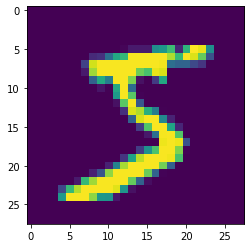

In [11]:
#Get a visual representation of a digit from the dataset
#X represents the numbers that we have as a visual representation in the dataset -> "data"

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image)
#plt.axis("off")
#plt.show()

print(y[0]) # the label says that the shown digit is: 5

In [17]:
#Split the data for training: - 60000 for the training set
#                             - 10000 for the test set

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

In [13]:
#Train a binary classifier to see if a digit is 5 or not
from sklearn.linear_model import SGDClassifier

y_train_5 = (y_train == "5") # True for all 5s, False for all other digits
y_test_5 = (y_test == "5")
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

print(sgd_clf.predict([some_digit])) # -> got [True]

[ True]


## Measure Performance

### Cross-Validation
- K-fold cross-validation means splitting the training set into K folds
- Making predictions and evaluating them on each fold using a model trained on the remaining folds

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

# We use StratifiedKFold for stratified sampling
# At each step we train a clone and predict the results
# 3 folds for this example

for i_train, i_test in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[i_train]
    y_train_folds = y_train_5[i_train]
    X_test_fold = X_train[i_test]
    y_test_fold = y_train_5[i_test]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
# -> 0.95035
# -> 0.96035
# -> 0.9604


C:\Users\Viniele\anaconda3\envs\House_price\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [15]:
from sklearn.model_selection import cross_val_score
# we can also use the cross_val_score function to do that, also with 3 folds

print(cross_val_score(sgd_clf, X_train,y_train_5, cv = 3, scoring = "accuracy")) # -> 0.95035 0.96035 0.9604

[0.95035 0.96035 0.9604 ]


### Confusion Matrix
- Count the number of times instances of class A are classified as class B
- We need to have a set of predictions so that they can be compared to the actual targets

In [16]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score
# to get the predictions set we use cross_val_predict function

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
print(confusion_matrix(y_train_5, y_train_pred))
# [[53892   687]   ->  [[true-negatives, false-positives]
# [ 1891  3530]]   ->  [false-negatives, true-positive]]


[[53892   687]
 [ 1891  3530]]


### Precision and Recall
- Best used for very precise testing

In [17]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)

# F1 score is the harmonic mean
# computing F1 from formula
print(2/(1/precision + 1/recall))

# computing F1 using f1_score() function
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)


0.7325171197343847


0.7325171197343846

### Precision/Recall Trade-off


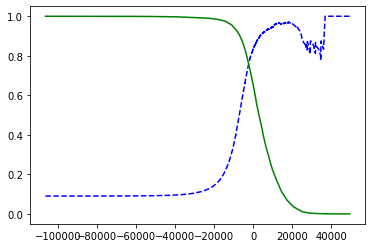

In [18]:
# we need to set a threshold and use the cross_val_predict() fct to do so
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,method="decision_function")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

### The ROC Curve (receiver operating characteristic)
- Similar to the precision/recall curve but it plots true and false positive rate
- The ROC curve plots sensitivity (recall) versus 1 – specificity

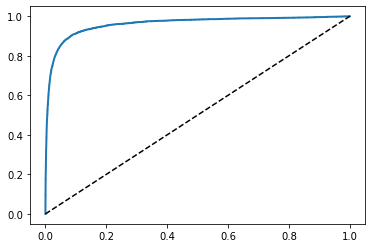

In [19]:
from sklearn.metrics import roc_curve
#We can use the roc_curve() to compute the TPR and FPR for thresholds

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal

plot_roc_curve(fpr, tpr)
plt.show()


In [20]:
from sklearn.metrics import roc_auc_score
# We can compare classifiers by measuring the area under the curve (AUC)

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

## Multiclass Classification


In [21]:
#Scikit-Learn detects when you try to use a binary classification algorithm for a multi‐
#class classification task, and it automatically runs OvR or OvO
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [22]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [23]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy"))

[0.87365 0.85835 0.8689 ]


In [24]:
from sklearn.preprocessing import StandardScaler
# scaling inputs to increase accuracy
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

### Error Analysis
- We need to analyze the types of errors the model makes, looking at the confusion matrix

In [25]:
# get a visual representation of the confusion matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)


[[5577    0   22    5    8   43   36    6  225    1]
 [   0 6400   37   24    4   44    4    7  212   10]
 [  27   27 5220   92   73   27   67   36  378   11]
 [  22   17  117 5227    2  203   27   40  403   73]
 [  12   14   41    9 5182   12   34   27  347  164]
 [  27   15   30  168   53 4444   75   14  535   60]
 [  30   15   42    3   44   97 5552    3  131    1]
 [  21   10   51   30   49   12    3 5684  195  210]
 [  17   63   48   86    3  126   25   10 5429   44]
 [  25   18   30   64  118   36    1  179  371 5107]]


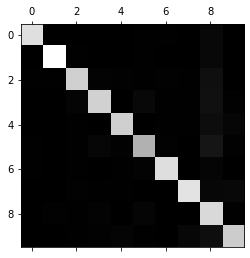

In [26]:
print(conf_mx)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

### Multilabel Classification
- Used for multiple recognitions, e.g. when we have multiple digits in the same image

In [27]:
# An example where we tell if a chosen digit is greater or equal to 7 and if it's odd
# So we are testing multiple features

#from sklearn.neighbors import KNeighborsClassifier

#y_train_large = (y_train >= 7)
#y_train_odd = (y_train % 2 == 1)
#y_multilabel = np.c_[y_train_large, y_train_odd]
#knn_clf = KNeighborsClassifier()
#knn_clf.fit(X_train, y_multilabel)


### Multioutput Classification
- It is simply a generalization of multilabel classification where each label can be multiclass

In [28]:
# As an example we take noisy images from the dataset and output clean digits
# Using NumPy’s randint() function

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test


In [29]:
# Train a model using KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

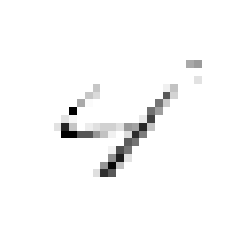

In [30]:
# Now let's see the number

clean_digit = knn_clf.predict([X_test_mod[420]])
some_digit_image = clean_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()


# Exercises


1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy
on the test set. Hint: the KNeighborsClassifier works quite well for this task;
you just need to find good hyperparameter values (try a grid search on the
weights and n_neighbors hyperparameters)


In [31]:
from sklearn.neighbors import KNeighborsClassifier

kn_classifier = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
kn_classifier.fit(X_train, y_train)
print(kn_classifier.predict([some_digit]))
print(cross_val_score(kn_classifier, X_train, y_train, cv=3, scoring="accuracy"))

# -> [0.9688  0.96795 0.96905] : close to 97%

['5']
[0.9688  0.96795 0.96905]


2. Write a function that can shift an MNIST image in any direction (left, right, up,
or down) by one pixel.5 Then, for each image in the training set, create four shifted copies
(one per direction) and add them to the training set. Finally, train your
best model on this expanded training set and measure its accuracy on the test set.
You should observe that your model performs even better now! This technique of
artificially growing the training set is called data augmentation or training set
expansion.

In [13]:
# Getting the data ready
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
X_train2, X_test2, y_train2, y_test2 = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
from scipy.ndimage.interpolation import shift

# We write the functions that are going to be used for shifting the images
def shift_left(image):
    image = image.reshape((28, 28))

    # 0 pixels down and 1 pixel to the left
    X_left = shift(image, [0, -1], cval=0, mode="constant")
    return X_left.reshape([-1])


def shift_right(image):
    image = image.reshape((28, 28))

    # 0 pixels down and 1 pixel to the right
    X_right = shift(image, [0, 1], cval=0, mode="constant")
    return X_right.reshape([-1])


def shift_down(image):
    image = image.reshape((28, 28))

    # 1 pixel down and 0 pixels to the right
    X_down = shift(image, [1, 0], cval=0, mode="constant")
    return X_down.reshape([-1])


def shift_up(image):
    image = image.reshape((28, 28))

    # 1 pixel up and 0 pixels to the right
    X_up = shift(image, [-1, 0], cval=0, mode="constant")
    return X_up.reshape([-1])

# Gathering all the  data that we need for training for all shifts + original dataset
print("Gathering data...")

X_train_augment = [i for i in X_train2]
y_train_augment = [i for i in y_train2]

for image, label in zip(X_train2, y_train2):
    X_train_augment.append(shift_left(image))
    X_train_augment.append(shift_right(image))
    X_train_augment.append(shift_down(image))
    X_train_augment.append(shift_up(image))
    for i in range(0, 4):
        y_train_augment.append(label)

# Mixing the data together
#print("Mixing it up...")

#mix_index = np.random.permutation(len(X_train_augment)-1)
#X_train_augment = np.array(X_train_augment)[mix_index]
#y_train_augment = np.array(y_train_augment)[mix_index]

Gathering data...
Training...
Testing...


NameError: name 'cross_val_score' is not defined

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Train the dataset using random forest classifier
print("Training...")

model_augment = RandomForestClassifier(random_state=42)
model_augment.fit(X_train_augment, y_train_augment)

Training...


RandomForestClassifier(random_state=42)

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Evaluate the created model
print("Testing...")

#print(cross_val_score(model_augment, X_train2, y_train2, cv=3, scoring="accuracy"))

y_pred_after_augmented = model_augment.predict(X_test)
score = accuracy_score(y_test, y_pred_after_augmented)
# We get 0.9792 accuracy


Testing...
Accuracy score after training on augmented dataset 0.9792
